In [1]:
# this model was fit to data
# with mass-ratio in 1,2
# and sampling the (coa_phase, inc) sphere
# s1z and s2z

In [1]:
import wispy.model_utils

In [2]:
import timeit

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [5]:
def plot_loghist(x, bins, axvlines=None):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.figure(figsize=(14, 6))
    plt.hist(x, bins=logbins, histtype='step', linewidth=4)
    plt.xscale('log')
    # plt.xlabel('mismatch')
    if axvlines is not None:
        for axvline in axvlines:
            plt.axvline(axvline, c='k')

In [6]:
history = wispy.model_utils.load_history("data_inc_coa_mass_ratio_s1z_s2z_hps_history.pickle")

In [7]:
history

{'loss': [0.00020415621111169457,
  7.665068551432341e-05,
  5.7791599829215556e-05,
  4.8455403884872794e-05],
 'val_loss': [0.00028388912323862314,
  0.0002572573721408844,
  0.00025086558889597654,
  0.0002560279972385615]}

In [8]:
import pandas as pd

In [9]:
import tensorflow as tf

2022-07-12 00:00:41.457228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 00:00:41.458103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
import corner_plot

In [11]:
import model_utils

In [12]:
!ls *.h5

data_amp_phi_1_saved_model.h5
data_inc_coa_hcs_saved_model.h5
data_inc_coa_hps_saved_model.h5
data_inc_coa_mass_ratio_hcs_saved_model.h5
data_inc_coa_mass_ratio_hps_saved_model.h5
data_inc_coa_mass_ratio_s1z_s2z_hcs_saved_model.h5
data_inc_coa_mass_ratio_s1z_s2z_hps_saved_model.h5
data_spin_saved_model.h5
saved_model.h5


In [13]:
model = tf.keras.models.load_model("data_inc_coa_mass_ratio_s1z_s2z_hps_saved_model.h5")

2022-07-12 00:01:00.962595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-12 00:01:00.962650: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 00:01:00.962684: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev5): /proc/driver/nvidia/version does not exist
2022-07-12 00:01:00.966028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 128)          1280        ['theta_input[0][0]']            
                                                                                              

In [15]:
# don't do this unless you take care of loading large datasets
print("load training data")
train_thetas = np.load("data_inc_coa_mass_ratio_s1z_s2z/train/theta.npy")
# train_times = np.load("data_inc_coa_mass_ratio_s1z_s2z/train/times.npy")
# train_hps = np.load("data_inc_coa_mass_ratio_s1z_s2z/train/hps.npy")
# train_hcs = np.load("data_inc_coa_mass_ratio_s1z_s2z/train/hcs.npy")

print("load validation data")
val_thetas = np.load("data_inc_coa_mass_ratio_s1z_s2z/val/theta.npy")
val_times = np.load("data_inc_coa_mass_ratio_s1z_s2z/val/times.npy")
val_hps = np.load("data_inc_coa_mass_ratio_s1z_s2z/val/hps.npy")
# val_hcs = np.load("data_inc_coa_mass_ratio/val/hcs.npy")

load training data
load validation data


In [16]:
[xx.shape for xx in [val_thetas, val_times, val_hps]]

[(500, 9), (4140, 1), (500, 4140)]

In [17]:
X = np.column_stack((val_times, (np.ones_like(val_times) * val_thetas[0])))

In [18]:
yhat = model([X[:,0], X[:,1:]])

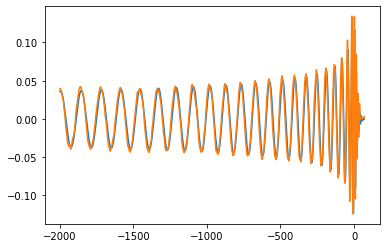

In [19]:
plt.plot(val_times, val_hps[0])
plt.plot(val_times, yhat)

(-100.0, 100.0)

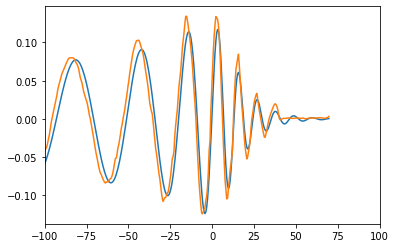

In [20]:
plt.plot(val_times, val_hps[0])
plt.plot(val_times, yhat)
plt.xlim(-100, 100)

# compute mse over validation set

In [21]:
def build_input_single(t, *args):
    """
    t is a matrix i.e. shape = (-1, 1)
    list of parameters
    """
    theta = np.array([*args])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [22]:
def build_input_multiple(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single(t, *theta) for theta in thetas])

In [23]:
X_val = build_input_multiple(val_times, val_thetas)

In [24]:
X_val.shape

(2070000, 10)

In [27]:
@tf.function()
def run_model_tf_func(X, model):
    return model([X[:,0], X[:,1:]])

In [28]:
@tf.function(jit_compile=True, reduce_retracing=True)
def run_model_tf_func_xla(X, model):
    return model([X[:,0], X[:,1:]])

In [29]:
val_thetas[0]

array([1.10668174, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3336399 , 2.53253004])

In [30]:
X_single_input_test = build_input_single(val_times, val_thetas[0])

In [31]:
X_single_input_test.shape

(4140, 10)

In [32]:
X_single_input_test[0]

array([-1.99975000e+03,  1.10668174e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.33639895e-01,  2.53253004e+00])

In [33]:
X_single_input_test = tf.convert_to_tensor(X_single_input_test)

In [34]:
%%timeit
_ = run_model_tf_func(X_single_input_test, model)

18.2 ms ± 8.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
_ = run_model_tf_func_xla(X_single_input_test, model)

2022-07-11 09:35:12.729588: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x56475a149950 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-11 09:35:12.729636: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-07-11 09:35:12.782259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


17.3 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2022-07-11 09:35:14.056094: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [36]:
####
# independent speed test: cpu


X_single_input_test = build_input_single(val_times, val_thetas[0])

X_single_input_test = tf.convert_to_tensor(X_single_input_test)


@tf.function                                                                     
def run_inference(X, model):                                            
    return model([X[:,0], X[:,1:]])                            
                                                                                 
@tf.function(jit_compile=True, reduce_retracing=True)                            
def run_inference_exp_comp(X, model):                                   
    return model([X[:,0], X[:,1:]])        

print('manual run_inference_exp_comp 1')                                         
start_time = timeit.default_timer()                                              
_ = run_inference_exp_comp(X_single_input_test, model)                                    
print(f"{(timeit.default_timer() - start_time)} seconds")
                                                                                 
print('manual run_inference_exp_comp 1')                                         
start_time = timeit.default_timer()                                              
_ = run_inference_exp_comp(X_single_input_test, model)                                    
print(f"{(timeit.default_timer() - start_time)}  seconds")
                                                                                 
print('manual run_inference_exp_comp 100')                                       
start_time = timeit.default_timer()                                              
for i in range(100):                                                             
    _ = run_inference_exp_comp(X_single_input_test, model)                                
print(f"{(timeit.default_timer() - start_time)/100} seconds")



####

manual run_inference_exp_comp 1
1.1017568241804838 seconds
manual run_inference_exp_comp 1
0.09413349581882358  seconds
manual run_inference_exp_comp 100
0.05468307537958026 seconds


In [25]:
%%time
yhat_val = model([X_val[:,0], X_val[:,1:]])

CPU times: user 56 s, sys: 43.8 s, total: 1min 39s
Wall time: 35.9 s


In [26]:
n_waveforms = val_thetas.shape[0]
n_times = val_times.shape[0]

In [27]:
yhat_val = yhat_val.numpy().reshape(n_waveforms, n_times)

In [28]:
val_thetas.shape

(500, 9)

In [29]:
yhat_val.shape

(500, 4140)

In [30]:
mses = tf.keras.losses.mse(yhat_val, val_hps).numpy()

In [31]:
tf.math.reduce_mean(mses)

<tf.Tensor: shape=(), dtype=float64, numpy=0.00025131728786163723>

In [32]:
mses.shape

(500,)

In [34]:
plt.figure()
plt.plot(mses, 'o')

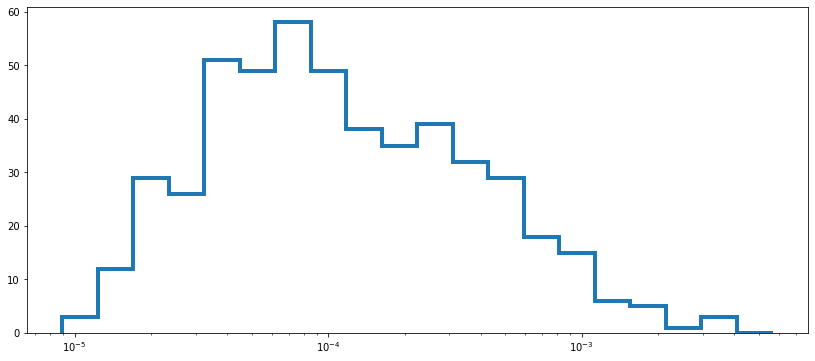

In [35]:
plot_loghist(mses, 20)

In [38]:
val_thetas[0]

array([ 1.43005356,  0.        ,  0.        , -0.10137617,  0.        ,
        0.        ,  0.85766737,  3.38798175,  1.36998117])

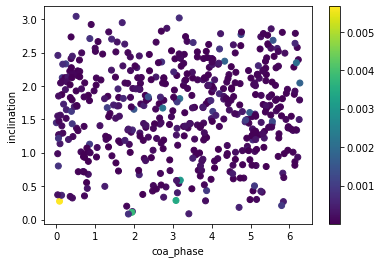

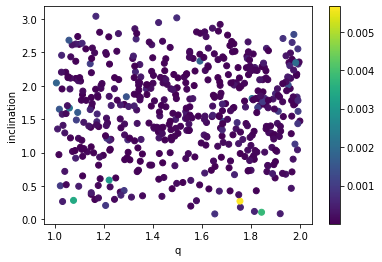

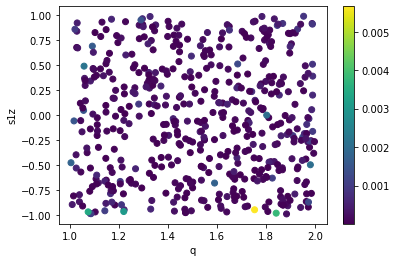

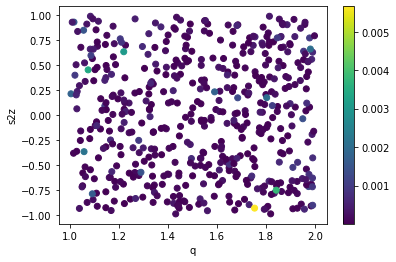

In [40]:
plt.figure()
plt.scatter(val_thetas[:,7], val_thetas[:,8], c=mses)
plt.xlabel('coa_phase')
plt.ylabel('inclination')
plt.colorbar()

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,7], c=mses)
plt.xlabel('q')
plt.ylabel('coa_phase')
plt.colorbar()

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,8], c=mses)
plt.xlabel('q')
plt.ylabel('inclination')
plt.colorbar()

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,3], c=mses)
plt.xlabel('q')
plt.ylabel('s1z')
plt.colorbar()

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,6], c=mses)
plt.xlabel('q')
plt.ylabel('s2z')
plt.colorbar()

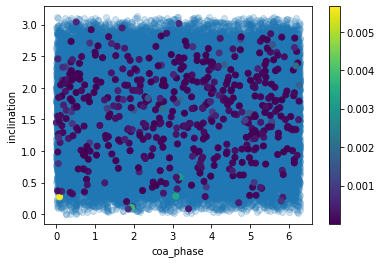

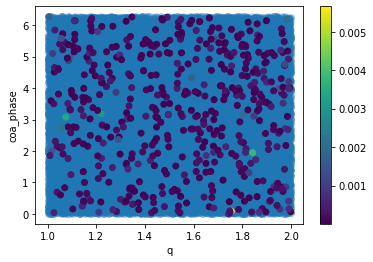

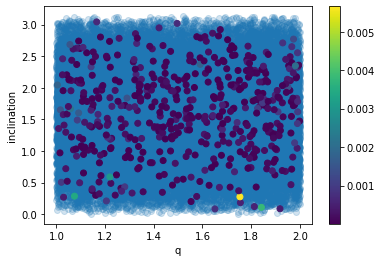

In [41]:
plt.figure()
plt.scatter(train_thetas[:,7], train_thetas[:,8], alpha=0.2)
plt.scatter(val_thetas[:,7], val_thetas[:,8], c=mses)
plt.xlabel('coa_phase')
plt.ylabel('inclination')
plt.colorbar()

plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,7], alpha=0.2)
plt.scatter(val_thetas[:,0], val_thetas[:,7], c=mses)
plt.xlabel('q')
plt.ylabel('coa_phase')
plt.colorbar()

plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,8], alpha=0.2)
plt.scatter(val_thetas[:,0], val_thetas[:,8], c=mses)
plt.xlabel('q')
plt.ylabel('inclination')
plt.colorbar()

In [42]:
worst_idx = mses.argmax()
worst_idx

230

In [43]:
val_thetas[worst_idx]

array([ 1.753856  ,  0.        ,  0.        , -0.94781985,  0.        ,
        0.        , -0.92686896,  0.08248555,  0.27438927])

In [44]:
plt.plot(val_times, val_hps[worst_idx])
plt.plot(val_times, yhat_val[worst_idx])

In [45]:
plt.plot(val_times, val_hps[worst_idx])
plt.plot(val_times, yhat_val[worst_idx])
plt.xlim(-100, 100)

(-100.0, 100.0)

In [46]:
df_mse = pd.DataFrame({'mse':mses})

In [53]:
df_mse = df_mse.sort_values(by='mse', ascending=False)

In [54]:
df_mse.index

Int64Index([230, 426, 307, 354, 287, 451, 277, 382, 134, 228,
            ...
            284, 480, 319,  60, 395, 429,  89, 310, 313, 386],
           dtype='int64', length=500)

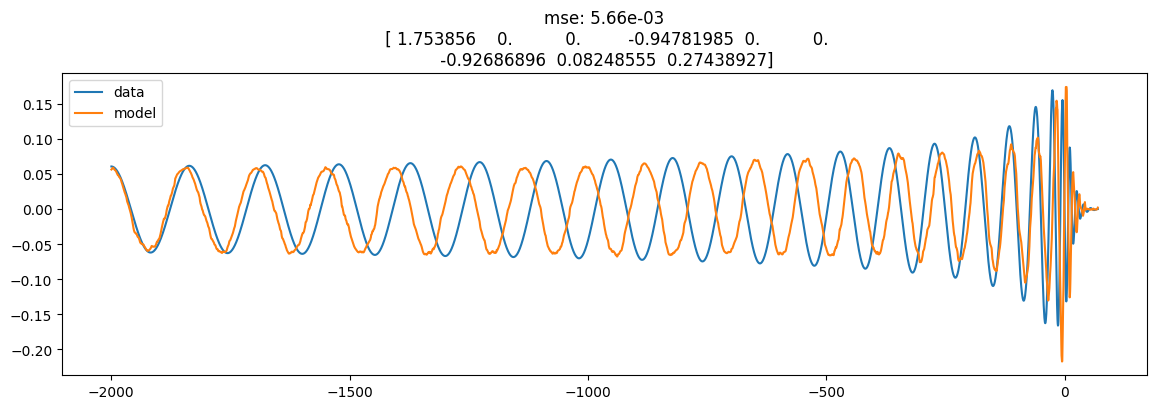

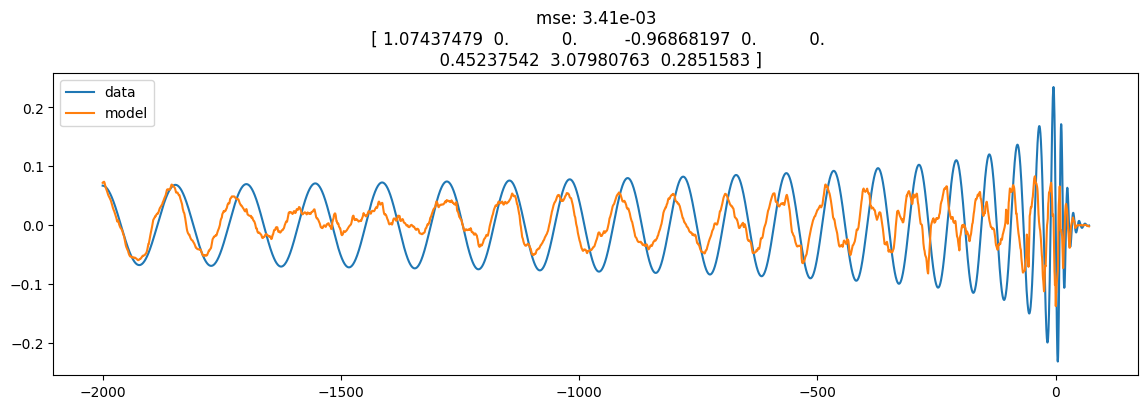

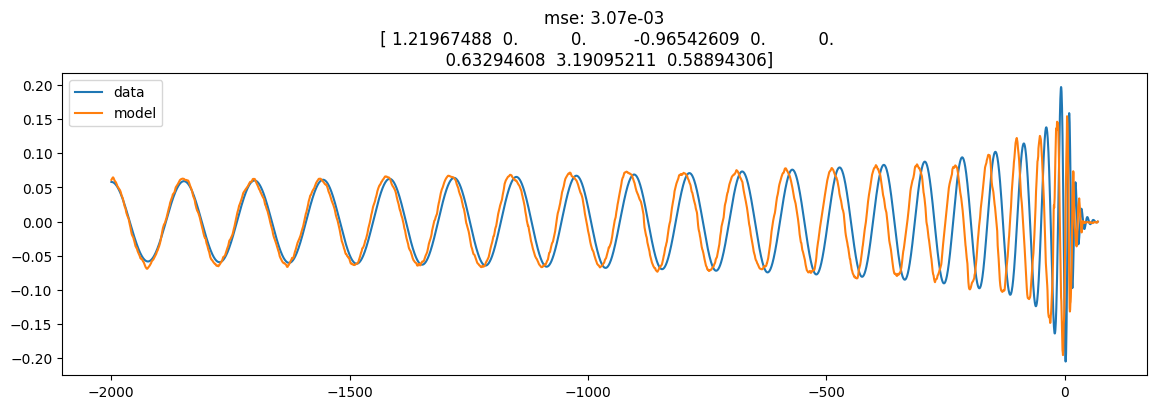

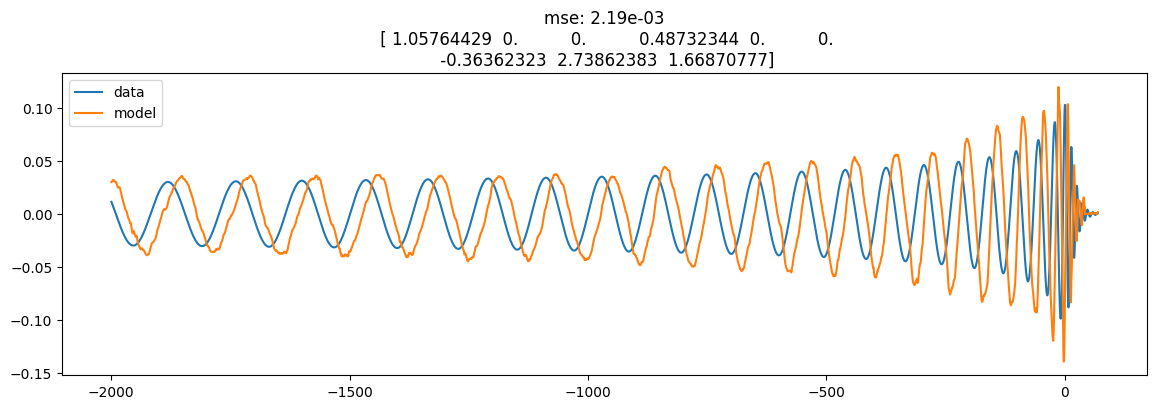

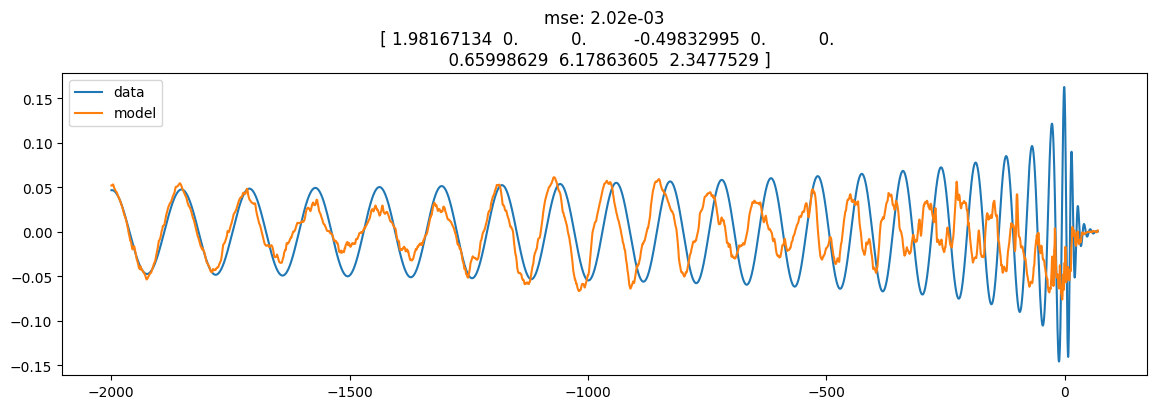

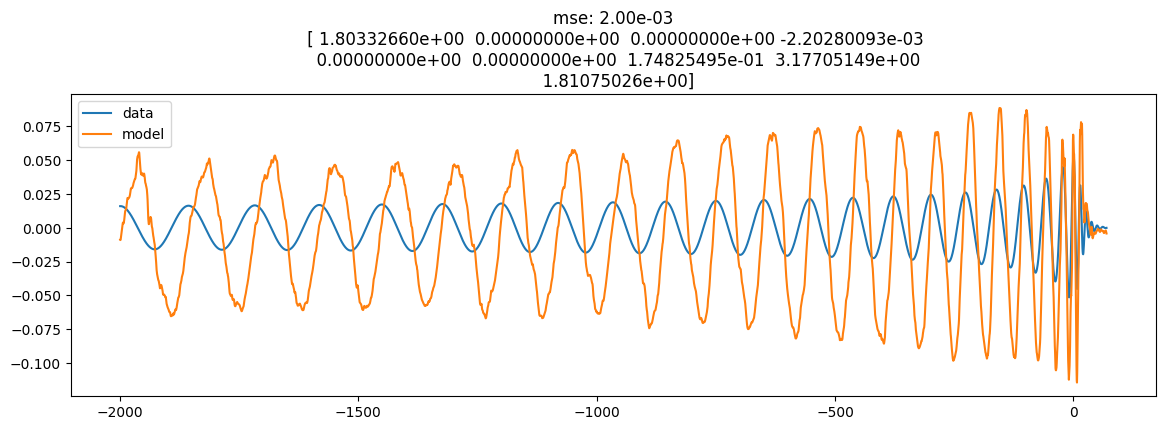

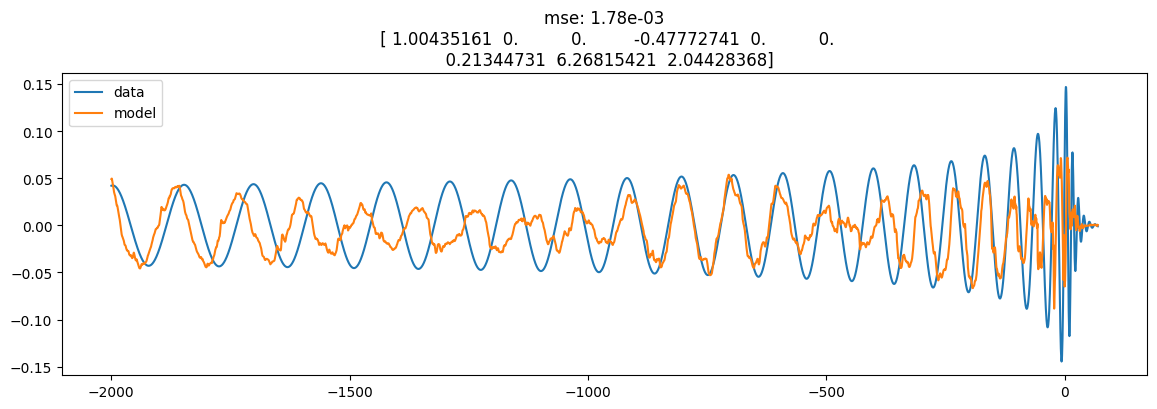

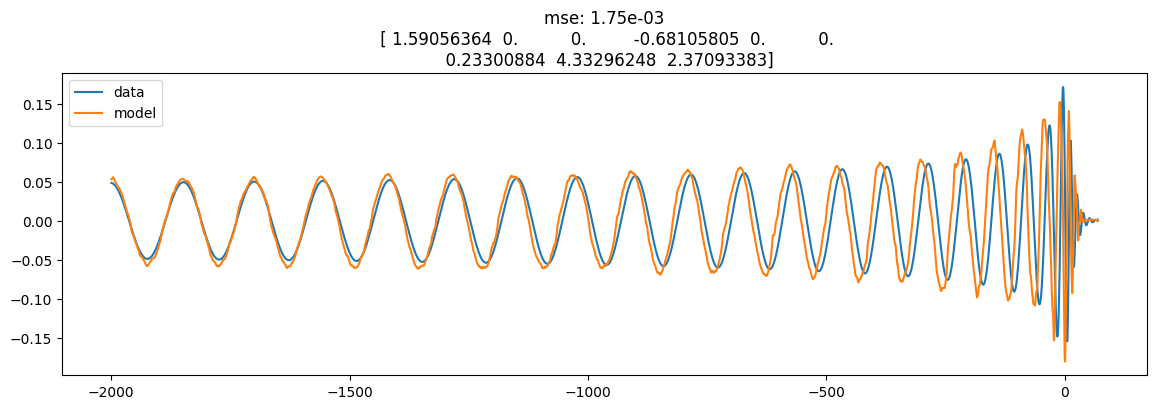

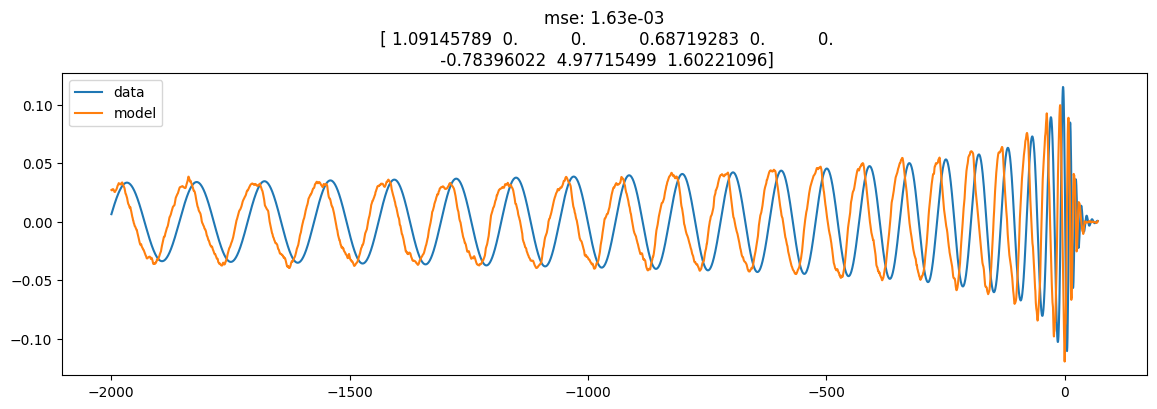

In [55]:
for i in df_mse.index[:10]:
    plt.figure(figsize=(14, 4), dpi=100)
    plt.plot(val_times, val_hps[i], label='data')
    plt.plot(val_times, yhat_val[i], label='model')
    # plt.xlim(-100, 100)
    plt.title(f"mse: {df_mse.loc[i].values[0]:.2e}\n {val_thetas[i]}")
    plt.legend()
    plt.show()
    plt.close()

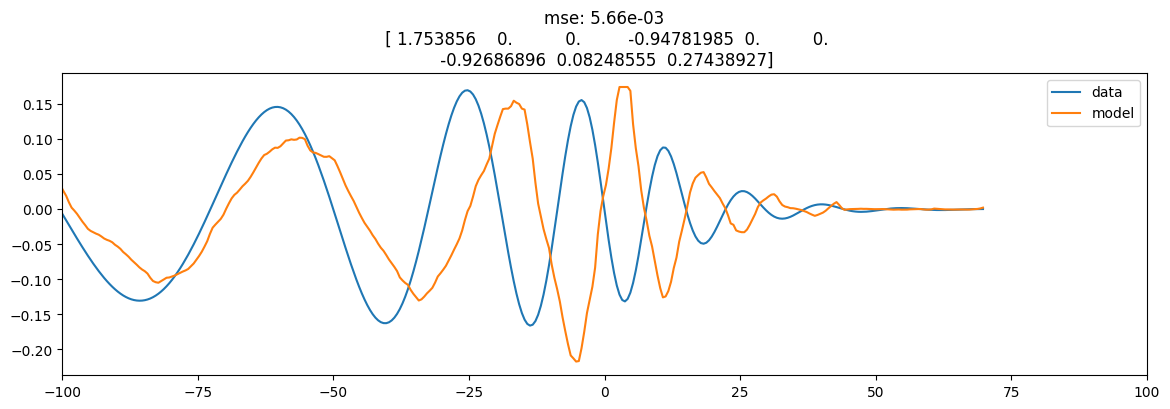

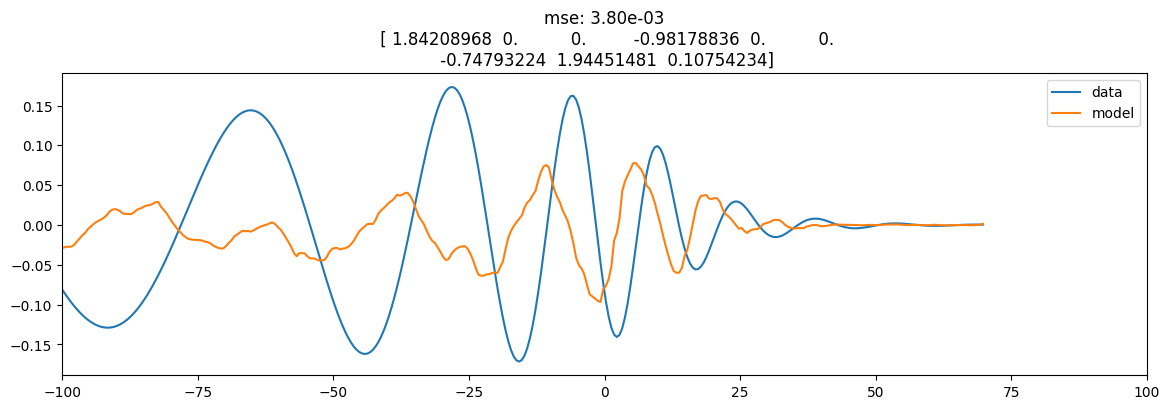

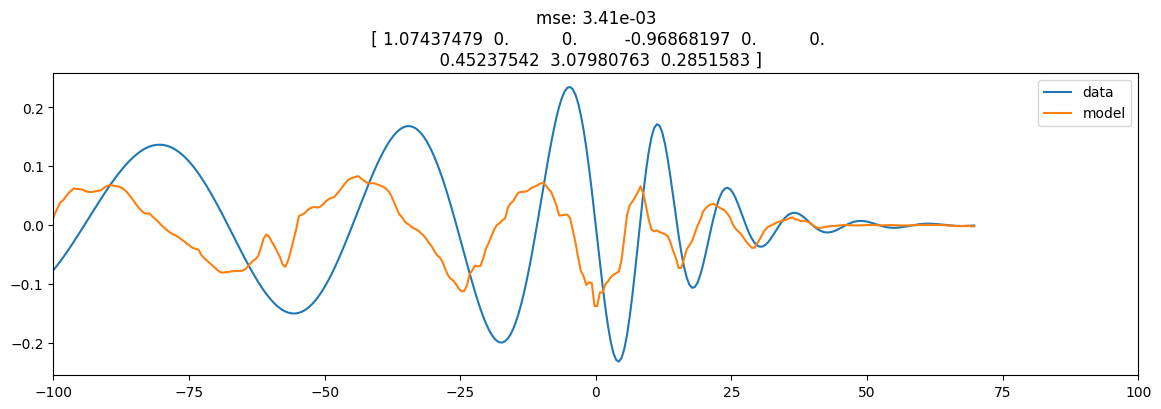

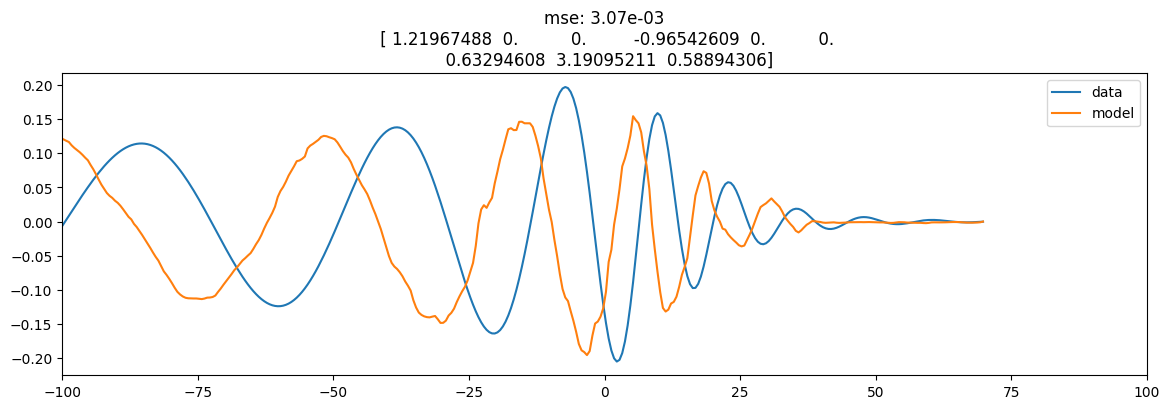

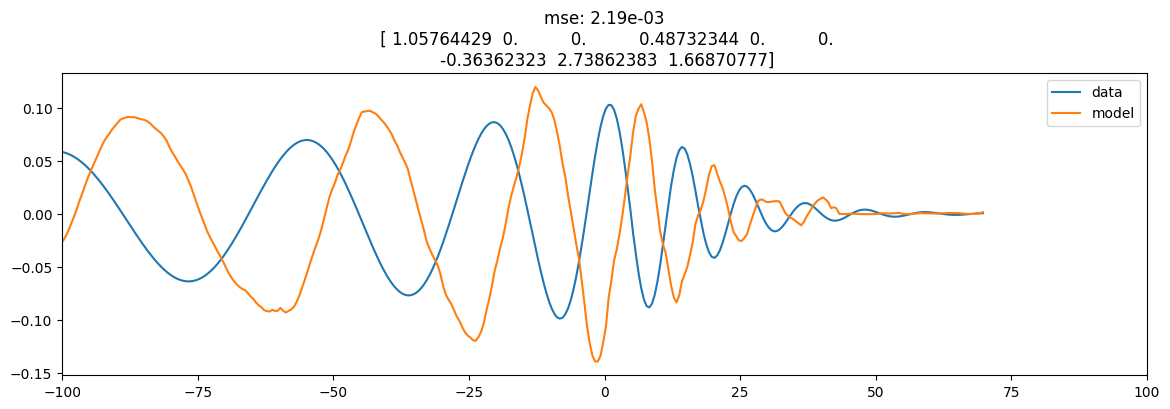

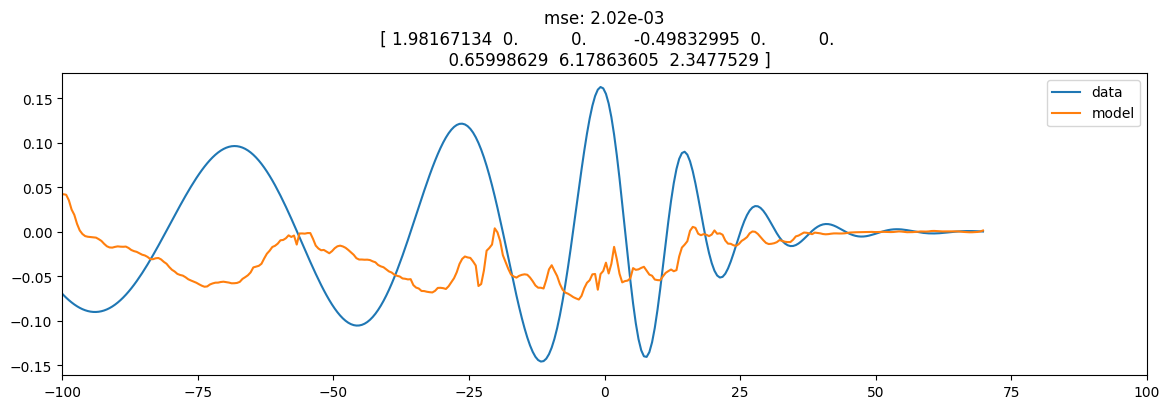

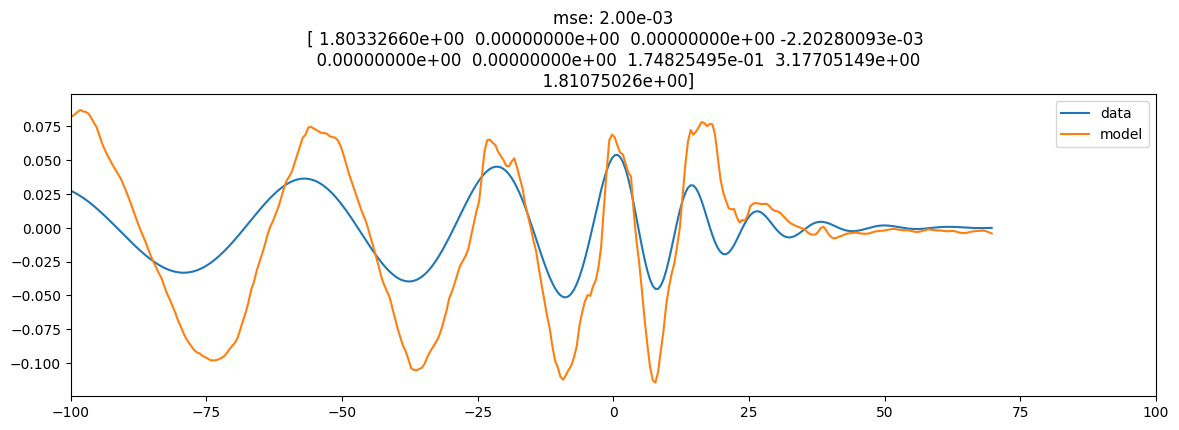

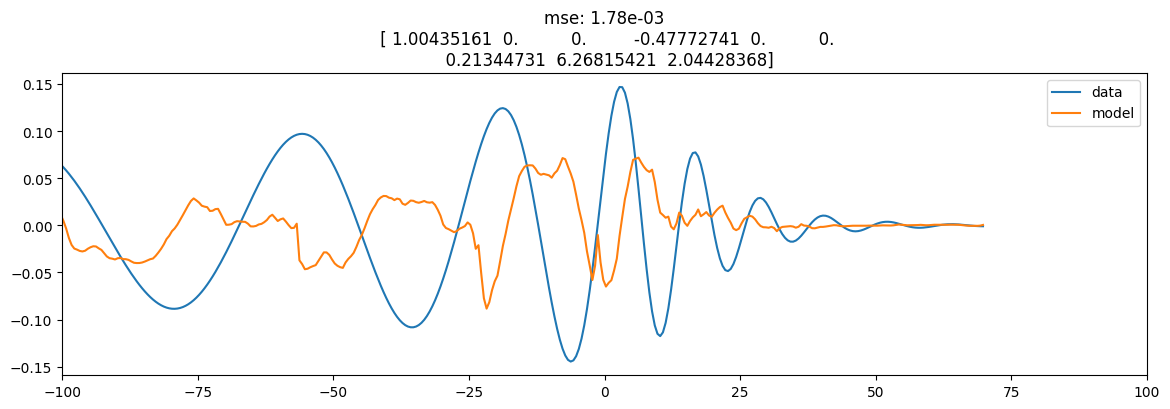

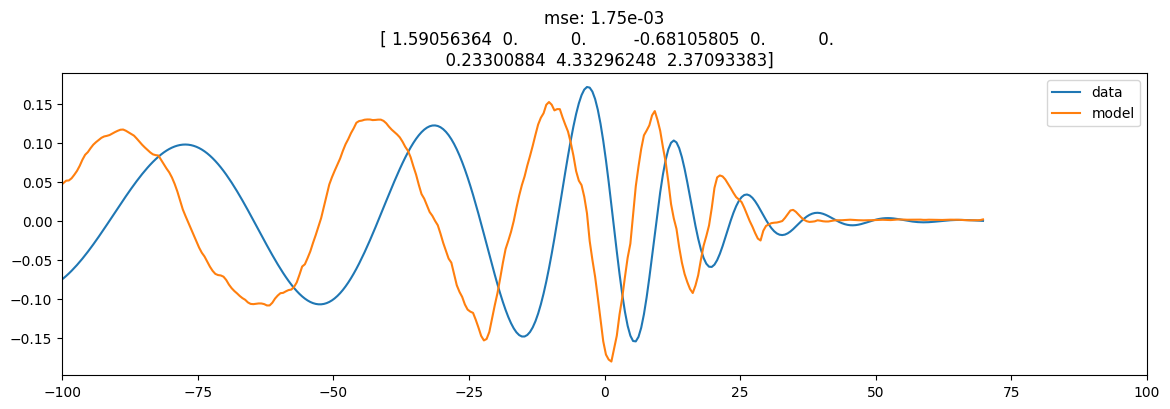

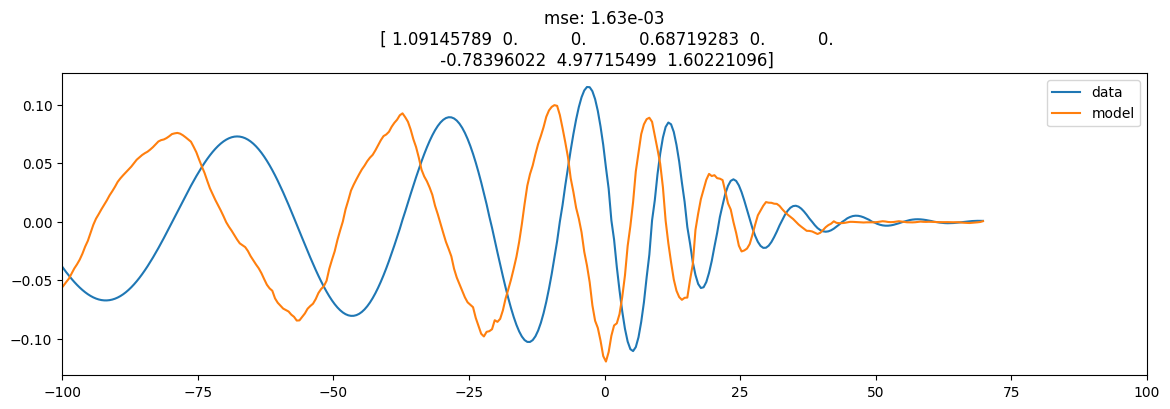

In [56]:
for i in df_mse.index[:10]:
    plt.figure(figsize=(14, 4), dpi=100)
    plt.plot(val_times, val_hps[i], label='data')
    plt.plot(val_times, yhat_val[i], label='model')
    plt.xlim(-100, 100)
    plt.title(f"mse: {df_mse.loc[i].values[0]:.2e}\n {val_thetas[i]}")
    plt.legend()
    plt.show()
    plt.close()

# compute matches

In [ ]:
import waveform

In [ ]:
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [ ]:
val_hps[0].dtype

In [ ]:
yhat_val[0].dtype

In [ ]:
def compute_match(h1, h2, times, total_mass):

    f_low = 30

    dt = times[1] - times[0]
    dt = waveform.MtoS(dt, total_mass)
    h1 = TimeSeries(h1.astype("double"), delta_t=dt)
    h2 = TimeSeries(h2.astype("double"), delta_t=dt)
    
    # # Resize the waveforms to the same length
    tlen = max(len(h1), len(h2))
    h1.resize(tlen)
    h2.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / h1.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, _ = match(h1, h2, psd=psd, low_frequency_cutoff=f_low)
    
    return m

In [ ]:
compute_match(val_hps[0], yhat_val[0], val_times[:,0], 100)

In [ ]:
%%time
all_matches = []
for i in range(len(val_hps)):
    m = compute_match(val_hps[i], yhat_val[i], val_times[:,0], 100)
    all_matches.append(m)
all_matches = np.array(all_matches)

In [ ]:
pd.DataFrame({'matches':all_matches}).describe()

In [ ]:
plot_loghist(1-all_matches, 20, axvlines=[1-0.97, 1-0.99])

In [ ]:
plt.figure()
plt.scatter(val_thetas[:,7], val_thetas[:,8], c=all_matches)
plt.colorbar()
plt.xlabel('coa_phase')
plt.ylabel('inclination')

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,7], c=all_matches)
plt.colorbar()
plt.xlabel('q')
plt.ylabel('inclination')

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,8], c=all_matches)
plt.colorbar()
plt.xlabel('q')
plt.ylabel('inclination')

In [ ]:
plt.figure()
plt.scatter(train_thetas[:,7], train_thetas[:,8], alpha=0.2)
plt.scatter(val_thetas[:,7], val_thetas[:,8], c=all_matches)
plt.xlabel('coa_phase')
plt.ylabel('inclination')

plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,7], alpha=0.2)
plt.scatter(val_thetas[:,0], val_thetas[:,7], c=all_matches)
plt.xlabel('q')
plt.ylabel('inclination')

plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,8], alpha=0.2)
plt.scatter(val_thetas[:,0], val_thetas[:,8], c=all_matches)
plt.xlabel('q')
plt.ylabel('inclination')

In [ ]:
df_matches = pd.DataFrame({'matches':all_matches})

In [ ]:
df_matches = df_matches.sort_values(by='matches', ascending=True)

In [ ]:
df_matches.index

In [ ]:
top_30_worst_idx = df_matches.index[:30]

In [ ]:
plt.figure()
plt.scatter(train_thetas[:,7], train_thetas[:,8], alpha=0.2)
plt.scatter(val_thetas[top_30_worst_idx,7], val_thetas[top_30_worst_idx,8], c=all_matches[top_30_worst_idx])
plt.xlabel('coa_phase')
plt.ylabel('inclination')

In [ ]:
# the worst cases are also the ones which are nearly edge-on
# the amplitude of the hx polarisation should kill off these cases.
# should really do SNR weighted matches....

In [ ]:
for i in df_matches.index[:30]:
    plt.figure(figsize=(14, 4), dpi=100)
    plt.plot(val_times, val_hps[i], label='data')
    plt.plot(val_times, yhat_val[i], label='model', ls='--')
    # plt.xlim(-100, 100)
    plt.title(f"{i}\n match: {df_matches.loc[i].values[0]:.4f}\n {val_thetas[i]}")
    plt.legend()
    plt.show()
    plt.close()